In [26]:
import numpy as np
from flask import Flask, render_template
import sqlite3
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import PorterStemmer, WordNetLemmatizer
import nltk
import re
import pickle

# Trianing the model

In [3]:
df=pd.read_table('data/SMSSpamCollection',
                header=None,
                names=['label','text']).astype('str')
df.head(10)

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [4]:
df.shape

(5572, 2)

In [5]:
stopwords = nltk.corpus.stopwords.words('english')
nltk.download('wordnet')
lemmetizer=WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/arash/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
def tokenize_and_lem(text):
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lemmas = [lemmetizer.lemmatize(t) for t in filtered_tokens]
    return lemmas

In [7]:
vectorizer=TfidfVectorizer(stop_words=stopwords,
                           lowercase=True,
                           tokenizer=tokenize_and_lem,
                            max_features=1000,
                           use_idf=False,
                            binary=True,
                            norm=None)
tfidf = vectorizer.fit_transform(df['text'])

/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [8]:
terms = vectorizer.get_feature_names()
tfidf_df=pd.SparseDataFrame(tfidf).fillna(0)
tfidf_df.index=df.index
tfidf_df.columns=terms

In [9]:
tfidf_df.head(10)

,'d,'ll,'m,'re,'s,'ve,*grins*,10p,10p/min,12hrs,...,yar,yeah,year,yep,yes,yesterday,yet,yo,yr,yup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
class_to_idx_dic = {"spam":1,"ham":0}
y = [class_to_idx_dic[yi] for yi in df.label]

In [11]:
from sklearn.model_selection import train_test_split, StratifiedKFold

xtrain, xtest, ytrain, ytest = train_test_split(tfidf_df,y,test_size=0.3,random_state=0)

In [12]:
cv=StratifiedKFold(n_splits=10)

In [13]:
from sklearn.naive_bayes import BernoulliNB
clf= BernoulliNB()
clf.fit(xtrain,ytrain)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [14]:
clf.score(xtest,ytest)

0.9826555023923444

In [15]:
from sklearn.metrics import confusion_matrix, roc_curve
ytest_pred=clf.predict(xtest)
confusion_matrix(ytest,ytest_pred)

array([[1446,    5],
       [  24,  197]])

In [16]:
ytest_pred_prob=clf.predict_proba(xtest)
fpr, tpr, thresholds = roc_curve(ytest, ytest_pred_prob[:,0], pos_label=1)

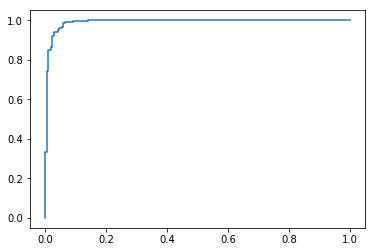

In [18]:
import matplotlib.pyplot as plt
plt.plot(tpr,fpr)
plt.show()

In [19]:
with open('model.pickle','wb') as fp:
    pickle.dump(clf,fp)

In [20]:
with open('pkl_objects/vectorizer.pickle','wb') as fp:
    pickle.dump(vectorizer,fp)

# Web APP

## Database

In [106]:
from datetime import datetime

In [21]:
from sqlite3 import Error
 
def sql_connection():
 
    try:
        connection = sqlite3.connect('spambank.sqlite')
        print("Connection is established: Database is created in memory")
        return connection

    except Error: 
        print(Error)

 
conn = sql_connection()

Connection is established: Database is created in memory


In [ ]:
cursor = conn.cursor()
# cursor.execute('CREATE TABLE spam_db (id integer PRIMARY KEY, message TEXT, label TEXT, date TEXT)')

In [136]:
#conn.commit()

In [134]:
cursor.execute("INSERT INTO spam_db VALUES (0, 'Promotional sale only today','spam',DATETIME('now') )")

In [124]:
# cursor.execute("DELETE from spam_db where id=0")

In [23]:
cursor.execute('SELECT * from spam_db')
results = cursor.fetchall()
print(results)

[(0, 'Promotional sale only today', 'spam', '2020-01-13 02:13:57')]


In [24]:
conn.close()